In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# predict BodyFat using Random Forest, XGBoost and Gradient Boosting
# then evaluate the models using mean squared error, mean aboslute and R^2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate

In [2]:
# read from csv
df = pd.read_csv('bodyfat.csv')

# swap Height and Weight columns
df['Height'], df['Weight'] = df['Weight'], df['Height']
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,67.75,154.25,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,72.25,173.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,66.25,154.00,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,72.25,184.75,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,71.25,184.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


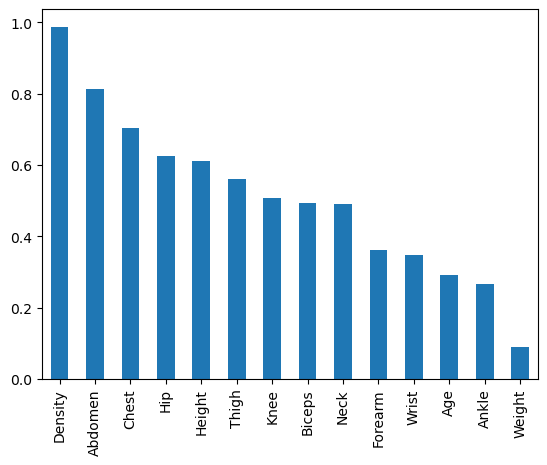

In [3]:
# show the absolute correlation between BodyFat and other features, order by descending
# then visualize the correlation and drop BodyFat in correlation
correlation = df.corr()['BodyFat'].abs().sort_values(ascending=False)
correlation.drop('BodyFat', inplace=True)
correlation.plot(kind='bar')
plt.show()

In [4]:
# get the features with correlation > 0.7
features = correlation[correlation > 0.7].index
X = df[features].astype(float)
y = df['BodyFat'].astype(float)

In [5]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# object to store the results for each model
mses = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
maes = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
r2s = {'Gradient Boosting': [], 'XGBoost': [], 'Random Forest': []}
best_params = {'Gradient Boosting': None, 'XGBoost': None, 'Random Forest': None}
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

Gradient Boosting
Mean Squared Error: 1.6073100397124818
R^2: 0.9777759415675308
Mean Absolute Error: 0.5735782083064503


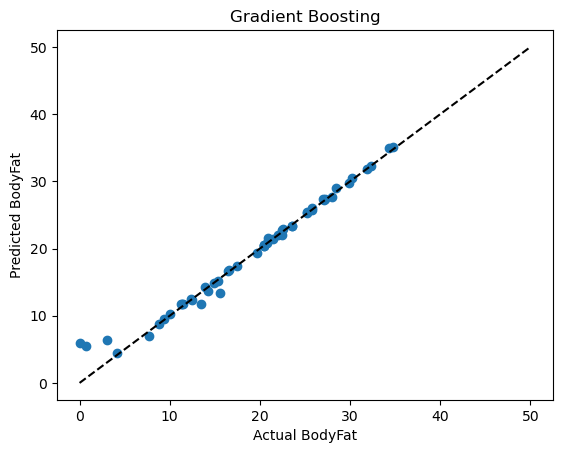

In [8]:
# Gradient Boosting, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
          model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
          scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
          # save scoring to array
          mses['Gradient Boosting'].append(-scores['test_neg_mean_squared_error'].mean())
          maes['Gradient Boosting'].append(-scores['test_neg_mean_squared_error'].mean())
          r2s['Gradient Boosting'].append(scores['test_r2'].mean())
          if scores['test_r2'].mean() > best_score:
              best_score = scores['test_r2'].mean()
              best_model = model
              best_params['Gradient Boosting'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

# fit the best model and predict the test
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Gradient Boosting')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BodyFat')
plt.ylabel('Predicted BodyFat')
plt.title('Gradient Boosting')
plt.show()

XGBoost
Mean Squared Error: 5.597825353266639
R^2: 0.9225996262874027
Mean Absolute Error: 0.7950345076766668


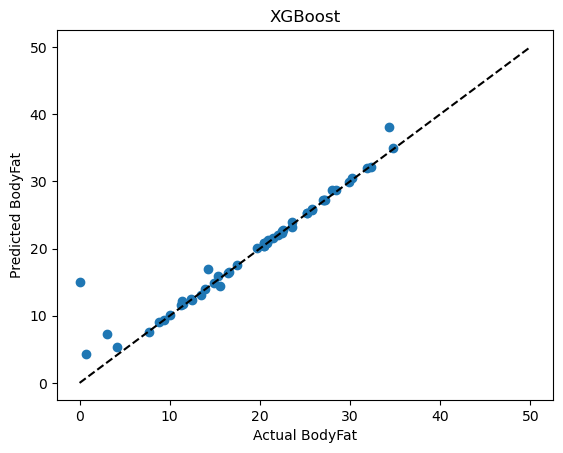

In [9]:
# XGBoost, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        for learning_rate in [0.01, 0.1, 0.3]:
            model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)
            # save scoring to array
            mses['XGBoost'].append(-scores['test_neg_mean_squared_error'].mean())
            maes['XGBoost'].append(-scores['test_neg_mean_absolute_error'].mean())
            r2s['XGBoost'].append(scores['test_r2'].mean())

            if scores['test_r2'].mean() > best_score:
                best_score = scores['test_r2'].mean()
                best_model = model
                best_params['XGBoost'] = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('XGBoost')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BodyFat')
plt.ylabel('Predicted BodyFat')
plt.title('XGBoost')
plt.show()

Random Forest
Mean Squared Error: 3.015185256610541
R^2: 0.9583094414444028
Mean Absolute Error: 0.735999080650883


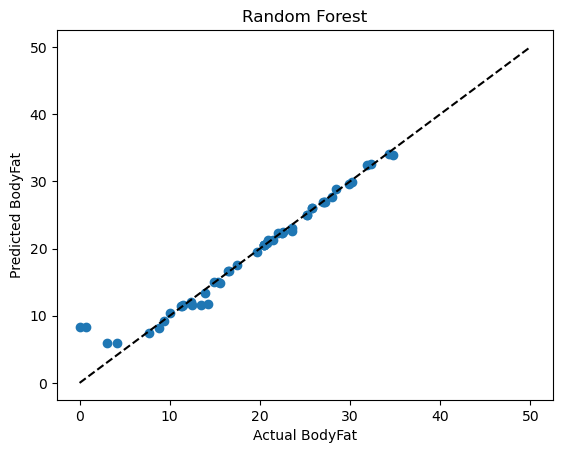

In [10]:
# Random Forest, avoid overfitting using cross-validation, tune the hyperparameters in loops
# then fit the model and predict the test in every loop, save the best hyperparameters and model
best_score = 0
best_model = None

for n_estimators in [100, 200, 300]:
    for max_depth in [3, 4, 5]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)
        # save scoring to array
        mses['Random Forest'].append(-scores['test_neg_mean_squared_error'].mean())
        maes['Random Forest'].append(-scores['test_neg_mean_absolute_error'].mean())
        r2s['Random Forest'].append(scores['test_r2'].mean())
        
        if scores['test_r2'].mean() > best_score:
            best_score = scores['test_r2'].mean()
            best_model = model
            best_params['Random Forest'] = {'n_estimators': n_estimators, 'max_depth': max_depth}

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluate the model using mean squared error and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Random Forest')
print('Mean Squared Error:', mse)
print('R^2:', r2)
print('Mean Absolute Error:', mae)

# plot the actual and predicted BodyFat
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual BodyFat')
plt.ylabel('Predicted BodyFat')
plt.title('Random Forest')
plt.show()

In [11]:
# show the best each score, best params of each measure for each model
for model in ['Gradient Boosting', 'XGBoost', 'Random Forest']:
    print(f'{model}')
    print(f'Best Mean Squared Error: {min(mses[model])}')
    print(f'Best Mean Absolute Error: {min(maes[model])}')
    print(f'Best R^2 Score: {max(r2s[model])}')
    print(f'Best Params: {best_params[model]}')
    print()

Gradient Boosting
Best Mean Squared Error: 2.329947645498693
Best Mean Absolute Error: 2.329947645498693
Best R^2 Score: 0.9662522016821077
Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3}

XGBoost
Best Mean Squared Error: 2.329134338407491
Best Mean Absolute Error: 0.4629941821214629
Best R^2 Score: 0.9673531371104295
Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

Random Forest
Best Mean Squared Error: 2.7470425752681353
Best Mean Absolute Error: 0.5029085236581984
Best R^2 Score: 0.9606956636273765
Best Params: {'n_estimators': 100, 'max_depth': 4}



In [12]:
# show them in dataframe for comparison, with the index is models
pd.options.display.float_format = '{:,.4f}'.format
df = pd.DataFrame({'Mean Squared Error': [min(mses['Random Forest']), min(mses['Gradient Boosting']), min(mses['XGBoost'])],
                   'Mean Absolute Error': [min(maes['Random Forest']), min(maes['Gradient Boosting']), min(maes['XGBoost'])],
                   'R^2': [max(r2s['Random Forest']), max(r2s['Gradient Boosting']), max(r2s['XGBoost'])]},
                  index=['Gradient Boosting', 'XGBoost', 'Random Forest'])
df

,Mean Squared Error,Mean Absolute Error,R^2
Gradient Boosting,2.7470,0.5029,0.9607
XGBoost,2.3299,2.3299,0.9663
Random Forest,2.3291,0.4630,0.9674


In [13]:
# show the best hyperparameters for each model in dataframe for comparison
# convert so that the index is the models
df = pd.DataFrame(best_params).T
df

,n_estimators,max_depth,learning_rate
Gradient Boosting,100.0000,3.0000,0.3000
XGBoost,100.0000,3.0000,0.1000
Random Forest,100.0000,4.0000,NaN
